In [4]:
! pip install memory_profiler
%load_ext memory_profiler 

Defaulting to user installation because normal site-packages is not writeable
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearnex import patch_sklearn  # Speeds up sklearn with intel patch
patch_sklearn()  # Activate patch - changes sklearn imports below

from timeit import default_timer as timer # Time how long commands take
from sklearn.model_selection import train_test_split, StratifiedKFold  # test_train split, cross-validation

from sklearn.experimental import enable_iterative_imputer  # Iterative imputer experimental so need to enable it
from sklearn.impute import IterativeImputer  # Once enabled iterative imputer can be imported

from sklearn.linear_model import RidgeClassifier, BayesianRidge  # Imputation
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder  # Normalisation & Encoding
from imblearn.under_sampling import TomekLinks, RandomUnderSampler   # Undersampling
from imblearn.over_sampling import SMOTENC  # Oversampling
from sklearn.feature_selection import RFE, RFECV  # Recursive feature elimination - feature selection
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier  # RFE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import validation_curve

import pickle
import shap

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Test Train Split

In [6]:
random_state=14

In [7]:
# Find which columns are categorical and which continuous
def cat_con_cols(df):
    
    columns = [list(df[i]) for i in df]  # Nested list of column values
    num_unique_vals = [len(set([i for i in a if pd.notna(i)])) for a in columns]  # Num of unique values in a column

    categorical_indexes = [i for i, v in enumerate(num_unique_vals) if v <= 100
                           and set([a % 1 for a in df[df.columns[i]].dropna()]) == {0}]

    continuous_indexes = [i for i, v in enumerate(num_unique_vals) if v > 100 or
                          set([a % 1 for a in df[df.columns[i]].dropna()]) != {0}]

    cat = list(df.columns[categorical_indexes])
    con = list(df.columns[continuous_indexes])
    return cat, con

# Data Cleaning

In [8]:
# Read in data

df = pd.read_csv('/data/home/bt211037/dissertation/feats_selected_dataset.tsv',sep='\t', header=0, index_col=0)


## Convert categorical columns to integers

In [9]:
# Get the column names of the continuous and categorical data

cat, con = cat_con_cols(df)  

In [10]:
# Convert categorical cols values from floats to integers 

df[cat] = df[cat].astype('Int64')  

## Separate categorical and Continuous features in dataframe¶

This makes indexing certain features in later processess easier. Continuous features are the first columns followed by categorical.

In [24]:
df = pd.concat([df[con], df[cat]], axis=1, join="inner")

# Column indexes for categorical and continuous features

# Important to exclude target feature - thryoid_cancer

categorical_indexes = [i for i, x in enumerate(df.columns[0:34]) if x in cat]

continuous_indexes = [i for i, x in enumerate(df.columns) if x in con]

# Test Train Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'thyroid_cancer'],

                                                        df['thyroid_cancer'],

                                                        test_size=0.2,

                                                        shuffle=True,

                                                        random_state=random_state,

                                                        stratify=df['thyroid_cancer'])

# Random Undersampling

In [26]:
# Configure random undersampler
rus = RandomUnderSampler(sampling_strategy=0.1,
                         random_state=random_state)


In [27]:
# Create the dataset used for hyperparamter tuning and training
X_res, y_res = rus.fit_resample(X_train, y_train.astype('float64'))

In [36]:
X_res

,Whole body fat-free mass|x23101_0_0,Whole body water mass|x23102_0_0,Leg fat percentage (right)|x23111_0_0,Leg predicted mass (right)|x23114_0_0,Leg fat percentage (left)|x23115_0_0,Leg fat-free mass (left)|x23117_0_0,Leg predicted mass (left)|x23118_0_0,Arm fat-free mass (right)|x23121_0_0,Arm predicted mass (right)|x23122_0_0,Arm fat-free mass (left)|x23125_0_0,...,Other eye problems|x2227_0_0,Falls in the last year|x2296_0_0,Acceptability of each blow result|x3061_0_0,Number of measurements made|x3137_0_0,Illness injury bereavement stress in last 2 years|x6145_0_0,Types of transport used (excluding work)|x6162_0_0,Illnesses of siblings|x20111_0_0,Spirometry QC measure|x20255_0_0,Genetic sex|x22001_0_0,Above moderate/vigorous/walking recommendation|x22036_0_0
0,40.1,29.4,38.0,6.3,38.6,6.5,6.2,2.1,1.9,2.1,...,0,2,<NA>,<NA>,0,1,3,<NA>,0,1
1,58.6,42.9,11.7,8.8,11.8,9.0,8.5,3.1,2.9,3.3,...,0,1,0,2,0,1,8,1,1,1
2,37.9,27.7,35.7,6.2,36.6,6.3,6.0,1.8,1.6,1.8,...,1,1,32,2,0,1,9,1,0,1
3,38.3,28.0,37.7,6.0,36.7,6.4,6.0,1.8,1.7,1.9,...,0,1,0,3,0,1,8,1,0,1
4,52.3,38.3,39.4,7.9,39.0,8.3,7.9,2.7,2.5,2.8,...,1,1,<NA>,<NA>,2,1,<NA>,<NA>,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6034,39.4,28.8,23.4,6.3,26.4,6.3,6.0,2.0,1.9,1.9,...,0,1,0,3,0,2,<NA>,2,0,1
6035,40.2,29.4,33.4,6.3,34.4,6.5,6.1,2.0,1.8,2.0,...,1,1,2,3,0,1,0,<NA>,0,1
6036,38.6,28.3,41.5,6.1,41.7,6.4,6.0,1.9,1.7,2.0,...,0,3,2,3,0,1,12,<NA>,0,<NA>
6037,35.9,26.3,33.3,5.8,34.0,6.0,5.6,1.6,1.5,1.6,...,0,1,0,2,0,1,0,<NA>,0,<NA>


# SHAP Analysis

### Random Forest (Extratreesclassifier)

In [57]:
rf_model = pickle.load(open('/data/home/bt211037/dissertation/rf_model.pkl', 'rb'))

In [58]:
rf_model

Pipeline(steps=[('imputer',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13]),
                                                 ('cat',
                                                  SimpleImputer(fill_value=4444,
                                                                strategy='constant'),
                                                  [14, 15, 16, 17, 18, 19, 20,
                                                   21, 22, 23, 24, 25, 26, 27,
                                                   28, 29, 30, 31, 32, 33])])),
                ('tomek', TomekLinks(sampling_strategy='majority')),
                ('smotenc',
                 SMOTENC(categorical_features=[14, 15, 16, 17, 18, 19, 20, 21,
                                               22, 23, 24, 25, 26, 27, 28, 29,
                                               30, 31, 32, 33],
                         random_state=14, sampling_strategy=1)),
                ('model',
                 ExtraTreesClassifier(bootstrap=True, max_depth=5,
                                      max_features=40, n_estimators=500,
                                      n_jobs=10, random_state=14))])

In [59]:
rf_model.named_steps

{'imputer': ColumnTransformer(transformers=[('num', SimpleImputer(strategy='median'),
                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                   13]),
                                 ('cat',
                                  SimpleImputer(fill_value=4444,
                                                strategy='constant'),
                                  [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                   25, 26, 27, 28, 29, 30, 31, 32, 33])]),
 'tomek': TomekLinks(sampling_strategy='majority'),
 'smotenc': SMOTENC(categorical_features=[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                               26, 27, 28, 29, 30, 31, 32, 33],
         random_state=14, sampling_strategy=1),
 'model': ExtraTreesClassifier(bootstrap=True, max_depth=5, max_features=40,
                      n_estimators=500, n_jobs=10, random_state=14)}

In [60]:
def shap_prepro(model, X, y, enc=True):
    
    # Imputation
    imp = model.named_steps['imputer'].fit_transform(X)
    # Encoding & Normalisation
    if enc:
        en_norm = model.named_steps['enc_norm'].fit_transform(imp) 
        # Tomek
        tomek_x, tomek_y = model.named_steps['tomek'].fit_resample(en_norm, y)
        # SMOTE
        smote_x, smote_y = model.named_steps['smotenc'].fit_resample(tomek_x, tomek_y)
        
    else:
        
        tomek_x, tomek_y = model.named_steps['tomek'].fit_resample(imp, y)
        # SMOTE
        smote_x, smote_y = model.named_steps['smotenc'].fit_resample(tomek_x, tomek_y)
        
        

    return smote_x, smote_y
    

In [61]:
X_shap, y_shap = shap_prepro(rf_model, X_res, y_res, False)

In [62]:
explainer = shap.TreeExplainer(rf_model.named_steps['model'])

In [63]:
shap_values = explainer.shap_values(X_shap, approximate=False, check_additivity=False)


Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


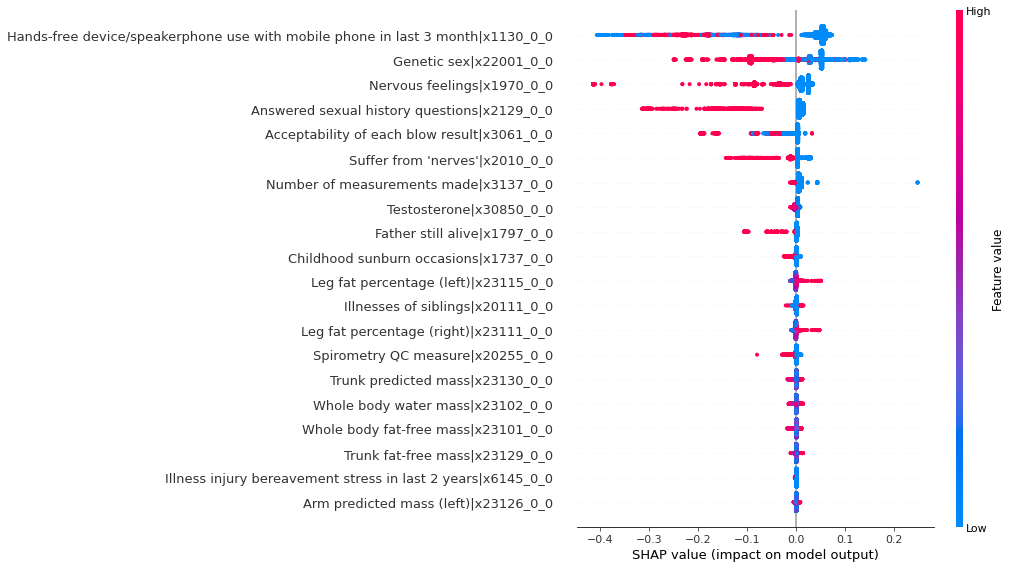

In [64]:
fig = shap.summary_plot(shap_values[1], X_shap, feature_names=list(X_train.columns))

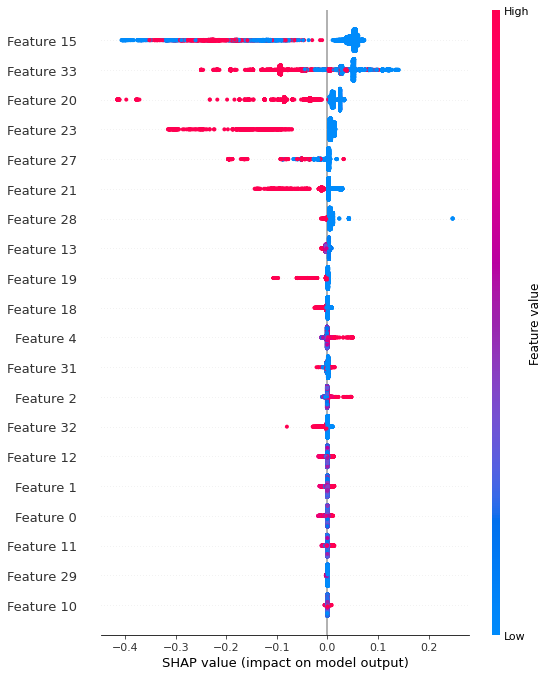

In [65]:
shap.summary_plot(shap_values[1], X_shap)